In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import os
import shutil
import torch
import time
import matplotlib.pyplot as plt
%matplotlib inline
from torch import Tensor
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms as tt
from torchvision import models
from torch.utils.data import DataLoader, ConcatDataset, Subset
from tempfile import TemporaryDirectory
from tqdm.notebook import tqdm
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, balanced_accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from torchsummary import summary

In [ ]:
# https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        # torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def all_scores(labels, preds):
    report = classification_report(labels, preds, digits=3, output_dict=True, zero_division=0)
    acc_sc = balanced_accuracy_score(labels, preds)
    f1_sc = report['macro avg']['f1-score']
    recall_sc = report['macro avg']['recall']
    precision_sc = report['macro avg']['precision']
    return acc_sc, f1_sc, recall_sc, precision_sc

def softmax(x):
    return np.exp(x)/sum(np.exp(x))

def auc_roc_sc(labels, probs):
    pred_soft = [softmax(x) for x in probs]
    return roc_auc_score(labels, pred_soft, average='macro', multi_class='ovr')

In [ ]:
! unzip -q '/content/drive/MyDrive/msc_thesis/data/fer_ckplus.zip'
! unzip -q '/content/drive/MyDrive/msc_thesis/data/kdef.zip'
! unzip -q '/content/drive/MyDrive/msc_thesis/data/rafdb_test.zip'
! unzip -q '/content/drive/MyDrive/msc_thesis/data/rafdb_train.zip'

In [ ]:
valid_size = 490

data_transforms = {
    'train': tt.Compose([tt.Resize((64,64)),
                        tt.Grayscale(num_output_channels=1),
                        tt.RandomHorizontalFlip(),
                        tt.RandomRotation(30),
                        tt.ToTensor()]),
    'val': tt.Compose([tt.Resize((64,64)),
                        tt.Grayscale(num_output_channels=1),
                        tt.ToTensor()]),
}

train_data = ImageFolder('/content/fer_ckplus', data_transforms['train'])
val_data = ImageFolder('/content/fer_ckplus', data_transforms['val'])

train_indices, val_indices, _, _ = train_test_split(
    range(len(train_data)),
    train_data.targets,
    stratify=train_data.targets,
    test_size=valid_size,
)

train_split = Subset(train_data, train_indices)
val_split = Subset(val_data, val_indices)
image_datasets = {
    'train': train_split,
    'val': val_split
    }

batch_size = 64
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size,
                                            shuffle=True, num_workers=2)
            for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# source for training funtion https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#training-the-model
def train_model(model, criterion, optimizer, scheduler, grad_clip, num_epochs=20, patience=10):
    since = time.time()
    results = {'acc': [], 'f1': [], 'rec': [], 'prec': [], 'roc': [], 'val_loss': [], 'train_loss': [], 'lr': []}

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        early_stopping = EarlyStopping(patience=patience, verbose=False)
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode
                    pred_list = []
                    label_list = []
                    output_list = []

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in tqdm(dataloaders[phase], leave=False, desc=phase):
                    if phase == 'val':
                        label_list = label_list + labels.tolist()

                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'val':
                            output_list = output_list + outputs.tolist()
                            pred_list = pred_list + preds.tolist()

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            if grad_clip:
                                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                            optimizer.step()
                            scheduler.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    train_loss = running_loss / dataset_sizes[phase]
                if phase == 'val':
                    val_loss = running_loss / dataset_sizes[phase]
                    acc, f1, prec, rec = all_scores(label_list, pred_list)
                    roc = auc_roc_sc(label_list, output_list)

                    results['acc'].append(acc)
                    results['f1'].append(f1)
                    results['prec'].append(prec)
                    results['rec'].append(rec)
                    results['roc'].append(roc)
                    results['val_loss'].append(val_loss)
                    results['train_loss'].append(train_loss)
                    results['lr'].append(get_lr(optimizer))

                    if epoch < 10:
                        s = '0'
                    else:
                        s = ''

                    print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
                        s+str(epoch), get_lr(optimizer), train_loss, val_loss, acc))

                # print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and acc > best_acc:
                    best_acc = acc
                    torch.save(model.state_dict(), best_model_params_path)

                    early_stopping(val_loss, model)

                    if early_stopping.early_stop:
                        print("Early stopping")
                        break

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model, results

In [ ]:
from torchvision.models.mnasnet import _get_depths, _InvertedResidual, _stack, _round_to_multiple_of

In [ ]:
# https://pytorch.org/vision/stable/_modules/torchvision/models/mnasnet.html
_BN_MOMENTUM = 1 - 0.9997

class MNASNet(torch.nn.Module):
    # Version 2 adds depth scaling in the initial stages of the network.
    _version = 2

    def __init__(self, alpha: float, num_classes: int = 7, dropout: float = 0.2) -> None:
        super().__init__()
        # _log_api_usage_once(self)
        if alpha <= 0.0:
            raise ValueError(f"alpha should be greater than 0.0 instead of {alpha}")
        self.alpha = alpha
        self.num_classes = num_classes
        depths = _get_depths(alpha)
        layers = [
            # First layer: regular conv.
            nn.Conv2d(1, depths[0], 3, padding=1, stride=2, bias=False),
            nn.BatchNorm2d(depths[0], momentum=_BN_MOMENTUM),
            nn.ReLU(inplace=True),
            # Depthwise separable, no skip.
            nn.Conv2d(depths[0], depths[0], 3, padding=1, stride=1, groups=depths[0], bias=False),
            nn.BatchNorm2d(depths[0], momentum=_BN_MOMENTUM),
            nn.ReLU(inplace=True),
            nn.Conv2d(depths[0], depths[1], 1, padding=0, stride=1, bias=False),
            nn.BatchNorm2d(depths[1], momentum=_BN_MOMENTUM),
            # MNASNet blocks: stacks of inverted residuals.
            _stack(depths[1], depths[2], 3, 2, 3, 3, _BN_MOMENTUM),
            _stack(depths[2], depths[3], 5, 2, 3, 3, _BN_MOMENTUM),
            _stack(depths[3], depths[4], 5, 2, 6, 3, _BN_MOMENTUM),
            _stack(depths[4], depths[5], 3, 1, 6, 2, _BN_MOMENTUM),
            _stack(depths[5], depths[6], 5, 2, 6, 4, _BN_MOMENTUM),
            _stack(depths[6], depths[7], 3, 1, 6, 1, _BN_MOMENTUM),
            # Final mapping to classifier input.
            nn.Conv2d(depths[7], 1280, 1, padding=0, stride=1, bias=False),
            nn.BatchNorm2d(1280, momentum=_BN_MOMENTUM),
            nn.ReLU(inplace=True),
        ]
        self.layers = nn.Sequential(*layers)
        self.classifier = nn.Sequential(nn.Dropout(p=dropout, inplace=True), nn.Linear(1280, num_classes))

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, mode="fan_out", nonlinearity="sigmoid")
                nn.init.zeros_(m.bias)

    def forward(self, x: Tensor) -> Tensor:
        x = self.layers(x)
        # Equivalent to global avgpool and removing H and W dimensions.
        x = x.mean([2, 3])
        return self.classifier(x)

In [ ]:
model = MNASNet(1.0, 7)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
max_lr = 0.001
epochs = 90
grad_clip = 0.2
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(dataloaders['train']))

In [ ]:
summary(model, (1,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             288
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]             288
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]             512
       BatchNorm2d-8           [-1, 16, 32, 32]              32
            Conv2d-9           [-1, 48, 32, 32]             768
      BatchNorm2d-10           [-1, 48, 32, 32]              96
             ReLU-11           [-1, 48, 32, 32]               0
           Conv2d-12           [-1, 48, 16, 16]             432
      BatchNorm2d-13           [-1, 48, 16, 16]              96
             ReLU-14           [-1, 48,

In [ ]:
model, results =  train_model(model, criterion, optimizer, scheduler, grad_clip, num_epochs=epochs, patience=4)

train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [00], last_lr: 0.00004, train_loss: 5.8113, val_loss: 1.8478, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [01], last_lr: 0.00005, train_loss: 4.7670, val_loss: 1.9457, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [02], last_lr: 0.00007, train_loss: 4.0788, val_loss: 2.0336, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [03], last_lr: 0.00009, train_loss: 2.9976, val_loss: 2.0076, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [04], last_lr: 0.00012, train_loss: 2.5475, val_loss: 1.9847, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [05], last_lr: 0.00015, train_loss: 2.3751, val_loss: 1.9191, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [06], last_lr: 0.00019, train_loss: 2.3421, val_loss: 1.8968, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [07], last_lr: 0.00023, train_loss: 2.2937, val_loss: 1.9114, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [08], last_lr: 0.00028, train_loss: 2.2946, val_loss: 1.8790, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [09], last_lr: 0.00033, train_loss: 2.2599, val_loss: 1.8993, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [10], last_lr: 0.00038, train_loss: 2.2761, val_loss: 1.8438, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [11], last_lr: 0.00044, train_loss: 2.2180, val_loss: 1.8374, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [12], last_lr: 0.00049, train_loss: 2.1574, val_loss: 1.8936, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [13], last_lr: 0.00055, train_loss: 2.0808, val_loss: 1.8317, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [14], last_lr: 0.00060, train_loss: 1.9676, val_loss: 1.8577, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [15], last_lr: 0.00066, train_loss: 1.8678, val_loss: 1.8627, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [16], last_lr: 0.00071, train_loss: 1.8483, val_loss: 1.8831, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [17], last_lr: 0.00076, train_loss: 1.7424, val_loss: 1.8811, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [18], last_lr: 0.00081, train_loss: 1.6660, val_loss: 1.8976, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [19], last_lr: 0.00085, train_loss: 1.6304, val_loss: 1.8708, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [20], last_lr: 0.00089, train_loss: 1.6657, val_loss: 1.8998, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [21], last_lr: 0.00092, train_loss: 1.8265, val_loss: 1.9021, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [22], last_lr: 0.00095, train_loss: 1.6347, val_loss: 1.8869, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [23], last_lr: 0.00097, train_loss: 1.7566, val_loss: 1.8900, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [24], last_lr: 0.00099, train_loss: 1.7572, val_loss: 1.8929, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [25], last_lr: 0.00100, train_loss: 1.6786, val_loss: 1.8844, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [26], last_lr: 0.00100, train_loss: 1.6349, val_loss: 1.8864, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [27], last_lr: 0.00100, train_loss: 1.5861, val_loss: 1.8749, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [28], last_lr: 0.00100, train_loss: 1.5753, val_loss: 1.8511, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [29], last_lr: 0.00099, train_loss: 1.4745, val_loss: 1.8614, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [30], last_lr: 0.00099, train_loss: 1.4020, val_loss: 1.8471, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [31], last_lr: 0.00098, train_loss: 1.2989, val_loss: 1.8828, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [32], last_lr: 0.00098, train_loss: 1.5101, val_loss: 1.8759, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [33], last_lr: 0.00097, train_loss: 1.3124, val_loss: 1.8487, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [34], last_lr: 0.00096, train_loss: 1.2663, val_loss: 1.8463, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [35], last_lr: 0.00095, train_loss: 1.2892, val_loss: 1.8733, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [36], last_lr: 0.00094, train_loss: 1.2973, val_loss: 1.8817, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [37], last_lr: 0.00093, train_loss: 1.2582, val_loss: 1.7945, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [38], last_lr: 0.00091, train_loss: 1.1903, val_loss: 1.8098, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [39], last_lr: 0.00090, train_loss: 1.1711, val_loss: 1.7985, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [40], last_lr: 0.00088, train_loss: 1.1470, val_loss: 1.8205, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [41], last_lr: 0.00087, train_loss: 1.1604, val_loss: 1.7901, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [42], last_lr: 0.00085, train_loss: 1.1550, val_loss: 1.7726, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [43], last_lr: 0.00083, train_loss: 1.1257, val_loss: 1.7356, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [44], last_lr: 0.00081, train_loss: 1.1142, val_loss: 1.7692, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [45], last_lr: 0.00079, train_loss: 1.0735, val_loss: 1.8183, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [46], last_lr: 0.00077, train_loss: 1.0717, val_loss: 1.8233, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [47], last_lr: 0.00075, train_loss: 1.0396, val_loss: 1.7889, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [48], last_lr: 0.00073, train_loss: 1.0656, val_loss: 1.7682, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [49], last_lr: 0.00071, train_loss: 1.0150, val_loss: 1.7392, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [50], last_lr: 0.00068, train_loss: 1.0042, val_loss: 1.8196, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [51], last_lr: 0.00066, train_loss: 0.9918, val_loss: 1.8422, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [52], last_lr: 0.00064, train_loss: 0.9769, val_loss: 1.8185, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [53], last_lr: 0.00061, train_loss: 0.9872, val_loss: 1.8006, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [54], last_lr: 0.00059, train_loss: 0.9602, val_loss: 1.8121, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [55], last_lr: 0.00056, train_loss: 0.9423, val_loss: 1.7847, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [56], last_lr: 0.00054, train_loss: 0.9487, val_loss: 1.7801, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [57], last_lr: 0.00051, train_loss: 0.9350, val_loss: 1.7174, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [58], last_lr: 0.00049, train_loss: 0.9199, val_loss: 1.8288, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [59], last_lr: 0.00046, train_loss: 0.9103, val_loss: 1.8149, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [60], last_lr: 0.00044, train_loss: 0.9189, val_loss: 1.7477, val_acc: 0.1451


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [61], last_lr: 0.00041, train_loss: 0.8926, val_loss: 1.7215, val_acc: 0.1451


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [62], last_lr: 0.00039, train_loss: 0.8777, val_loss: 1.6657, val_acc: 0.1609


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [63], last_lr: 0.00036, train_loss: 0.8797, val_loss: 1.7675, val_acc: 0.1429


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [64], last_lr: 0.00034, train_loss: 0.8634, val_loss: 1.6958, val_acc: 0.1561


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [65], last_lr: 0.00032, train_loss: 0.8550, val_loss: 1.6560, val_acc: 0.1605


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [66], last_lr: 0.00029, train_loss: 0.8494, val_loss: 1.6339, val_acc: 0.1627


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [67], last_lr: 0.00027, train_loss: 0.8428, val_loss: 1.5695, val_acc: 0.1789


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [68], last_lr: 0.00025, train_loss: 0.8240, val_loss: 1.5898, val_acc: 0.1871
EarlyStopping counter: 1 out of 4


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [69], last_lr: 0.00023, train_loss: 0.8195, val_loss: 1.5700, val_acc: 0.1859


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [70], last_lr: 0.00021, train_loss: 0.8110, val_loss: 1.5564, val_acc: 0.2048


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [71], last_lr: 0.00019, train_loss: 0.8050, val_loss: 1.4798, val_acc: 0.2434


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [72], last_lr: 0.00017, train_loss: 0.7933, val_loss: 1.4347, val_acc: 0.2657


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [73], last_lr: 0.00015, train_loss: 0.7849, val_loss: 1.3867, val_acc: 0.2819


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [74], last_lr: 0.00013, train_loss: 0.7819, val_loss: 1.3830, val_acc: 0.2864


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [75], last_lr: 0.00012, train_loss: 0.7739, val_loss: 1.3269, val_acc: 0.3152


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [76], last_lr: 0.00010, train_loss: 0.7608, val_loss: 1.2906, val_acc: 0.3626


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [77], last_lr: 0.00009, train_loss: 0.7636, val_loss: 1.2743, val_acc: 0.3601


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [78], last_lr: 0.00007, train_loss: 0.7510, val_loss: 1.1456, val_acc: 0.4347


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [79], last_lr: 0.00006, train_loss: 0.7464, val_loss: 1.1362, val_acc: 0.4438


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [80], last_lr: 0.00005, train_loss: 0.7438, val_loss: 1.0931, val_acc: 0.4541


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [81], last_lr: 0.00004, train_loss: 0.7361, val_loss: 1.1061, val_acc: 0.4798
EarlyStopping counter: 1 out of 4


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [82], last_lr: 0.00003, train_loss: 0.7336, val_loss: 1.0325, val_acc: 0.5022


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [83], last_lr: 0.00002, train_loss: 0.7405, val_loss: 0.9953, val_acc: 0.5155


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [84], last_lr: 0.00002, train_loss: 0.7295, val_loss: 0.9688, val_acc: 0.5346


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [85], last_lr: 0.00001, train_loss: 0.7283, val_loss: 0.9359, val_acc: 0.5440


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [86], last_lr: 0.00001, train_loss: 0.7301, val_loss: 0.8718, val_acc: 0.5960


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [87], last_lr: 0.00000, train_loss: 0.7240, val_loss: 0.8841, val_acc: 0.5912


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [88], last_lr: 0.00000, train_loss: 0.7238, val_loss: 0.8619, val_acc: 0.6254


train:   0%|          | 0/496 [00:00<?, ?it/s]

val:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch [89], last_lr: 0.00000, train_loss: 0.7247, val_loss: 0.8331, val_acc: 0.6497
Training complete in 70m 38s
Best val Acc: 0.649721


In [ ]:
kdef_ds = ImageFolder('/content/kdef', data_transforms['val'])
kdef_test_dl = DataLoader(kdef_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

model.eval()
label_list = []
output_list = []
pred_list = []
for inputs, labels in tqdm(kdef_test_dl, leave=False, desc='Test'):
    label_list = label_list + labels.tolist()

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        output_list = output_list + outputs.tolist()
        pred_list = pred_list + preds.tolist()
acc, f1, prec, rec = all_scores(label_list, pred_list)
roc = auc_roc_sc(label_list, output_list)

print('acc:', round(acc, 4), ', roc:', round(roc, 4), ', f1:', round(f1, 4), ', recall:', round(rec, 4))

Test:   0%|          | 0/8 [00:00<?, ?it/s]

acc: 0.5163 , roc: 0.8783 , f1: 0.4572 , recall: 0.4894


In [ ]:
test_raf_ds = ImageFolder('/content/rafdb_test', data_transforms['val'])
test_raf_dl = DataLoader(test_raf_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

model.eval()
label_list = []
output_list = []
pred_list = []
for inputs, labels in tqdm(test_raf_dl, leave=False, desc='Test'):
    label_list = label_list + labels.tolist()

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        output_list = output_list + outputs.tolist()
        pred_list = pred_list + preds.tolist()
acc, f1, prec, rec = all_scores(label_list, pred_list)
roc = auc_roc_sc(label_list, output_list)

print('acc:', round(acc, 4), ', roc:', round(roc, 4), ', f1:', round(f1, 4), ', recall:', round(rec, 4))

Test:   0%|          | 0/48 [00:00<?, ?it/s]

acc: 0.3992 , roc: 0.8475 , f1: 0.385 , recall: 0.5354


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/msc_thesis/notebooks/mnasnet.pt')

In [ ]:
print(results)

{'acc': [0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14

In [ ]:
results = {'acc': [0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14512471655328799, 0.14512471655328799, 0.16086181061118404, 0.14285714285714285, 0.15607471058598876, 0.16049382716049385, 0.16274150985930436, 0.17893562993107626, 0.18712124225908686, 0.1858614790945618, 0.20483062675692135, 0.24341584641983527, 0.2657235999305963, 0.28191354789177014, 0.28640095920804043, 0.3152152551540222, 0.3625620515245157, 0.3601200826474269, 0.43474033141783985, 0.4438185063657028, 0.4541069859126004, 0.4797651339907407, 0.5022349021742133, 0.515514063020638, 0.5345909239875624, 0.543970025369662, 0.5960499452561516, 0.5912371921928884, 0.625447970507378, 0.6497207244200408], 'f1': [0.06242879927090454, 0.06242879927090454, 0.03836446239273094, 0.03836446239273094, 0.03836446239273094, 0.03836446239273094, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.040530397798348765, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06242879927090454, 0.06252852578731173, 0.06242879927090454, 0.06252852578731173, 0.06709285714285715, 0.06699281150159744, 0.09750378414124446, 0.06252852578731173, 0.087658526817281, 0.09540391630788944, 0.10116285198321825, 0.12971180108980712, 0.14274172615495723, 0.13913477570415295, 0.1683322723897566, 0.21653096634387933, 0.2448438286682713, 0.27306125997410907, 0.2755961869593603, 0.31393593030881295, 0.37837706332169735, 0.36056279425315224, 0.44906259912618623, 0.4612316732651349, 0.4685073218380421, 0.4983345595089208, 0.5129295014045322, 0.5280553904688097, 0.5541731008824926, 0.5667871375742298, 0.6216819791934489, 0.6188330104028441, 0.644396811506094, 0.6730743679159534], 'rec': [0.03994169096209913, 0.03994169096209913, 0.022157434402332362, 0.022157434402332362, 0.022157434402332362, 0.022157434402332362, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.02361516034985423, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.03994169096209913, 0.040023371311714864, 0.03994169096209913, 0.040023371311714864, 0.1829625292740047, 0.1828805141688577, 0.3504682207611078, 0.040023371311714864, 0.20735570735570735, 0.30888739143456123, 0.3229225867562215, 0.4358365568449602, 0.3637277133075453, 0.32903383575652484, 0.400910698177213, 0.4820650298749193, 0.41273346527034327, 0.5912085142540306, 0.5857722832722833, 0.5836434447675666, 0.7106031970943467, 0.5751550196881678, 0.7001056220447659, 0.690104997995747, 0.6968081728892148, 0.7164169404777568, 0.7069313528484423, 0.7091805124714191, 0.7069590787693655, 0.6850269293124548, 0.7270240172499072, 0.7133966424326209, 0.6959595115739049, 0.7327146610726603], 'prec': [0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14512471655328799, 0.14512471655328799, 0.16086181061118404, 0.14285714285714285, 0.15607471058598876, 0.16049382716049385, 0.16274150985930436, 0.17893562993107626, 0.18712124225908686, 0.1858614790945618, 0.20483062675692135, 0.24341584641983527, 0.2657235999305963, 0.28191354789177014, 0.28640095920804043, 0.3152152551540222, 0.3625620515245157, 0.3601200826474269, 0.43474033141783985, 0.4438185063657028, 0.4541069859126004, 0.4797651339907407, 0.5022349021742133, 0.515514063020638, 0.5345909239875624, 0.543970025369662, 0.5960499452561516, 0.5912371921928884, 0.625447970507378, 0.6497207244200408], 'roc': [0.5202222669055169, 0.5135406838947792, 0.5020701836703388, 0.5034685454807214, 0.49510794018257515, 0.49798765872070067, 0.4668486784189087, 0.4966851598737932, 0.5090625887180039, 0.5006824256259074, 0.48518701539678094, 0.49440689115196473, 0.4972666343987209, 0.5152267745488596, 0.4931530825680826, 0.5261281587946327, 0.5148906004672416, 0.564711589246367, 0.5703359481471291, 0.5264422684888285, 0.5532859624765297, 0.5470763361866028, 0.5953153747955169, 0.5925045091240847, 0.6193312105797089, 0.6444645886821757, 0.6422637737612124, 0.6854420974102261, 0.6826362784246159, 0.7010687672318081, 0.7102081192513311, 0.7092313590759673, 0.7101305629056983, 0.7527981684606956, 0.7670500191242827, 0.7656592782175355, 0.7702425742637261, 0.7915050461587773, 0.763961470188771, 0.8107640331800494, 0.7992722334077655, 0.7948068992857332, 0.8129884492452808, 0.8186095449141295, 0.8324630994110773, 0.8252890251616598, 0.8282459854486807, 0.847174673587277, 0.8403766677511688, 0.8414301427488747, 0.81778989483148, 0.838479239559202, 0.8236169707128218, 0.8488957087446348, 0.8466198322710327, 0.8482165849857691, 0.843171359033776, 0.855848661522683, 0.8488420761189002, 0.8158968269311939, 0.8443003584318457, 0.8489259061172951, 0.8544401015382064, 0.8419305548253909, 0.8413177799375579, 0.8524996388022092, 0.8522890412893839, 0.8667885105141995, 0.8562385398586104, 0.8681283904497467, 0.8657291824341328, 0.8778140774980029, 0.8802101830128001, 0.8834860972267217, 0.8880776815391714, 0.8932862219930736, 0.8982418271702779, 0.8947241639548933, 0.9101575680067849, 0.9050256814657763, 0.9116663731145688, 0.9054827738025172, 0.9142523631638257, 0.9171190238473234, 0.9265965870545051, 0.9241920236659763, 0.9298604122117162, 0.9296411970364472, 0.930399928743319, 0.9315902756283313], 'val_loss': [1.8478435905612245, 1.9457454754381764, 2.033598221078211, 2.0075804150834378, 1.9846825069310714, 1.9190630372689694, 1.896803261309254, 1.9114338159561157, 1.8789790226488696, 1.8992585454668318, 1.843785912649972, 1.837384778626111, 1.893649993624006, 1.8316667167507872, 1.8576863045595131, 1.862714965489446, 1.883115214231063, 1.8810522945559756, 1.8975771845603475, 1.8707711501997344, 1.899755225376207, 1.902120345465991, 1.8868904220814608, 1.89002714984271, 1.8928712625892794, 1.8844351680911318, 1.8864071787620078, 1.8749084871642443, 1.8510985899944694, 1.8613570996693203, 1.8470941650624177, 1.8828184585182035, 1.8758636085354552, 1.8487387360358725, 1.846345796877024, 1.873332015835509, 1.8817043839668741, 1.7944589853286743, 1.8097827789734822, 1.798506230724101, 1.8204959373084866, 1.790127032143729, 1.7726132495062692, 1.7356041231933905, 1.7692379192430145, 1.8182924698810188, 1.8233115789841632, 1.7888796606842352, 1.7682424297138137, 1.7391595295497349, 1.819581701317612, 1.8422353817492114, 1.8184860978807722, 1.8006118978772845, 1.8120988140300829, 1.7846579566293834, 1.780102251987068, 1.7174046759702721, 1.8288159925110485, 1.8149462398217648, 1.7477242065935719, 1.72153856413705, 1.6656952857971192, 1.7674634174424775, 1.6958001127048414, 1.6560096594752098, 1.6339463053917398, 1.569499092685933, 1.5897559759568194, 1.570018954179725, 1.556384819381091, 1.4798002320892958, 1.4347451458171923, 1.3866965381466612, 1.38302427262676, 1.3268857629931703, 1.290602202804721, 1.2742907202973657, 1.1455530643463134, 1.1362263168607438, 1.0931065646969542, 1.1060900821977733, 1.0325025986651986, 0.995312272772497, 0.9687706971655087, 0.9358886494928477, 0.871843881509742, 0.8841386984805671, 0.8619081000892483, 0.8330799380127265], 'train_loss': [5.8112568624557985, 4.767032400254281, 4.078845112073806, 2.9975558194902634, 2.5475228270215373, 2.3751032785061867, 2.3421122292357106, 2.293736348469411, 2.294597538007844, 2.2599454834576576, 2.276111023560647, 2.217996180297867, 2.157425346393739, 2.0808176422311413, 1.9676415771245956, 1.8678198425519852, 1.8482610835663733, 1.7424391861404143, 1.6660243051667367, 1.6304345859154579, 1.6656891513736016, 1.8265290892412585, 1.6346714934033733, 1.7565598603217834, 1.757172744841345, 1.6786137405903108, 1.6348906092105373, 1.5860842018117827, 1.5753063588373122, 1.474544016343932, 1.4019726087008753, 1.298918412697892, 1.5101295678365616, 1.3123556873010052, 1.2662559694820834, 1.2891697922060568, 1.297346749973874, 1.2582109191965671, 1.1903195813778908, 1.1711244199785493, 1.1470103905566278, 1.1603950230825333, 1.1550481641484844, 1.1256601026942652, 1.114205717800125, 1.0734931542988746, 1.071663243035155, 1.0395649523744661, 1.0656065183781809, 1.0150045471325997, 1.0042455298525672, 0.9918037011258064, 0.9769019192505267, 0.9871597645744201, 0.9602480993395851, 0.9422548260659941, 0.9486963937599813, 0.9349850434209069, 0.9198563791090443, 0.9103041507544056, 0.9188769087195396, 0.892587261454713, 0.8777254078417055, 0.8796644820080649, 0.8633620689713186, 0.8549919366355865, 0.849418300294107, 0.8427589787470717, 0.823982834455467, 0.8194855944283547, 0.8110319832640309, 0.8049816307761977, 0.7933119292701444, 0.7849044813023459, 0.7819336672583895, 0.7739436405921175, 0.7608415354043245, 0.7636252302195756, 0.7510490088813728, 0.7464421144536426, 0.7437975747931388, 0.7361258849982293, 0.7335959605031437, 0.7405105196540395, 0.7295109253496893, 0.7282914195450083, 0.7300955455509885, 0.7240247346100307, 0.7237790245562792, 0.7247140220096034], 'lr': [4.324607249658419e-05, 5.2940385875282266e-05, 6.895182161929477e-05, 9.106382022362389e-05, 0.00011897731022779455, 0.00015231475324769758, 0.00019062525029627745, 0.00023339064032853454, 0.00028003250852617987, 0.00032992000953277294, 0.00038237839982772687, 0.00043669816383624395, 0.0004921446103417866, 0.000547967809406709, 0.0006034127354011946, 0.0006577294789529692, 0.000710183389698085, 0.0007600650126490086, 0.0008066996837876319, 0.0008494566550999119, 0.00088775762563329, 0.0009210845631917625, 0.0009489867108778133, 0.0009710866837156114, 0.0009870855728968072, 0.0009967669886124545, 0.000999999997473068, 0.0009993759548939996, 0.0009975103899806281, 0.0009944079408212706, 0.0009900763205933658, 0.0009845262983872998, 0.00097777167243275, 0.0009698292357941133, 0.0009607187346203005, 0.0009504628190526999, 0.0009390869869133568, 0.0009266195203133702, 0.0009130914153391087, 0.0008985363049910555, 0.0008829903755668704, 0.0008664922766965522, 0.0008490830252533688, 0.0008308059033794464, 0.000811706350879547, 0.0007918318522505517, 0.000771231818627521, 0.0007499574649398274, 0.0007280616825827717, 0.00070559890792124, 0.0006826249869523242, 0.0006591970364633736, 0.0006353733020306619, 0.000611213013211708, 0.0005867762362912628, 0.0005621237249470618, 0.0005373167692066096, 0.0005124170430705143, 0.0004874864511812046, 0.00046258697491823535, 0.00043778051830281145, 0.00041312875409463745, 0.00038869297046371996, 0.0003645339186183204, 0.00034071166176787845, 0.00031728542579641077, 0.0002943134520176302, 0.00027185285237786485, 0.00024995946746675943, 0.00022868772768877216, 0.00020809051794061197, 0.0001882190461310538, 0.00016912271587000784, 0.00015084900364336238, 0.00013344334077895797, 0.00011694900049714957, 0.00010140699032676132, 8.685595015390971e-05, 7.333205615715733e-05, 6.086893086783435e-05, 4.9497559579126644e-05, 3.924621331175594e-05, 3.0140378527766904e-05, 2.220269376716765e-05, 1.5452893364951626e-05, 9.907758388431883e-06, 5.581074916863558e-06, 2.48359976707845e-06, 6.230337503438279e-07, 4.002526932047755e-09]}

In [ ]:
def plot_scores(results):
    plt.figure(figsize=(8, 6), dpi=150)
    epochs = len(results['acc'])
    # plt.plot(results['prec'], color='limegreen', label='precision')
    plt.plot(results['rec'], color='orange', label='recall')
    plt.plot(results['f1'], color='dodgerblue', label='f1-score')
    plt.plot(results['roc'], color = 'blueviolet', label='roc-auc')
    plt.plot(results['acc'], color='red', label='accuracy')
    plt.ylabel('performance scores')
    plt.ylim([0,1])
    plt.legend(loc='lower right')
    plt.xlabel('epoch')
    plt.title('Model performance vs. No. of epochs')
    plt.show()

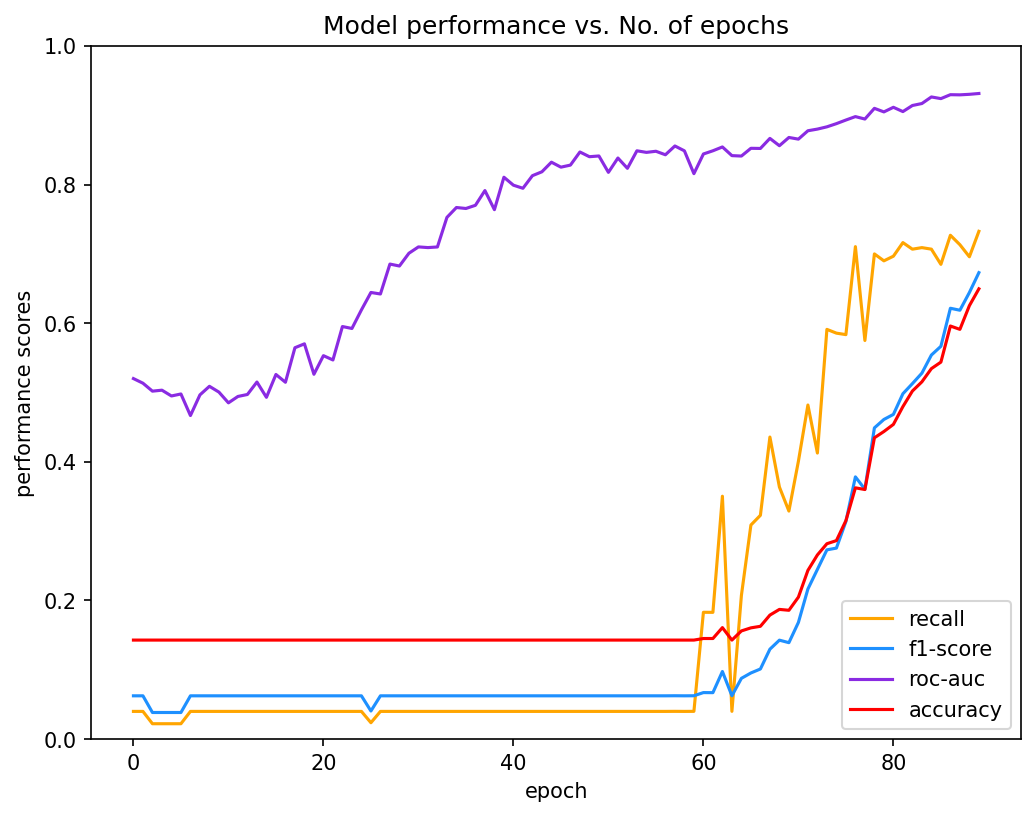

In [ ]:
plot_scores(results)

In [ ]:
criterion = nn.CrossEntropyLoss()
model = MNASNet(1.0, 7)
model.load_state_dict(torch.load('/content/drive/MyDrive/msc_thesis/notebooks/mnasnet2.pt'))
model = model.to(device)

In [ ]:
! unzip -q '/content/drive/MyDrive/msc_thesis/data/kdef_faces.zip'
criterion = nn.CrossEntropyLoss()
kdef_f_ds = ImageFolder('/content/kdef_faces', data_transforms['val'])
kdef_f_test_dl = DataLoader(kdef_f_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

model.eval()
label_list = []
output_list = []
pred_list = []
for inputs, labels in tqdm(kdef_f_test_dl, leave=False, desc='Test'):
    label_list = label_list + labels.tolist()

    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        output_list = output_list + outputs.tolist()
        pred_list = pred_list + preds.tolist()
acc, f1, prec, rec = all_scores(label_list, pred_list)
roc = auc_roc_sc(label_list, output_list)

print('acc:', round(acc, 4), ', roc:', round(roc, 4), ', f1:', round(f1, 4), ', recall:', round(rec, 4))

Test:   0%|          | 0/8 [00:00<?, ?it/s]

acc: 0.7224 , roc: 0.9463 , f1: 0.71 , recall: 0.7457
